In [ ]:
!pip3 install pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 9.9 MB/s eta 0:00:00


In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange, tqdm

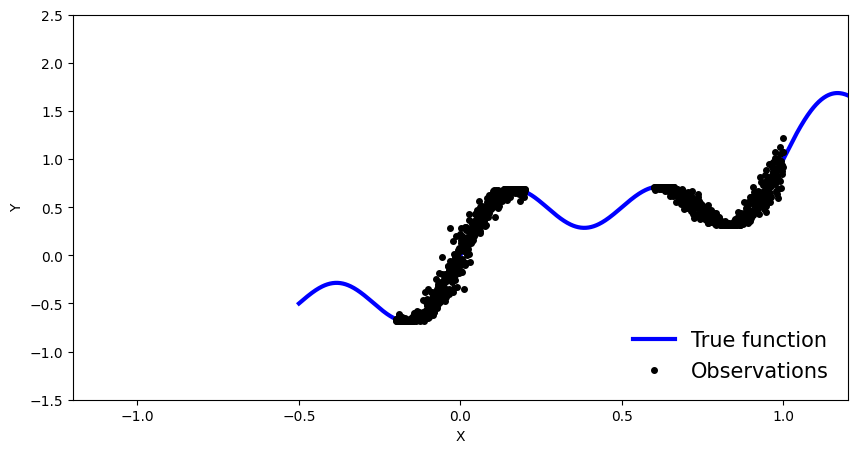

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate data
#x_obs = np.linspace(-1, 1, 1000)
#x_obs = np.hstack([np.linspace(-1, -0.8, 300),  np.linspace(-0.6, -0.3, 300),np.linspace(0, 0.25, 300), np.linspace(0.75, 1, 300)])
#noise = np.hstack([0.01 * np.random.randn(300), 0.05 * np.random.randn(300),0.05 * np.random.randn(300),0.01 * np.random.randn(300)])
#y_obs=0.5*x_obs+0.5*np.sinc(2 * np.pi * (x_obs/2 )) + noise

#x_true = np.linspace(-1.2, 1.2, 1000)
#y_true=0.5*x_true+0.5*np.sinc(2 * np.pi * (x_true/2 ))




x_obs = np.hstack([np.linspace(-0.2, 0.2, 500), np.linspace(0.6, 1, 500)])
noise = 0.02 * np.random.randn(x_obs.shape[0])
y_obs = x_obs + 0.3 * np.sin(2 * np.pi * (x_obs + noise)) + 0.3 * np.sin(4 * np.pi * (x_obs + noise)) + noise

x_true = np.linspace(-0.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

# Set plot limits and labels
xlims = [-0.5, 1.5]
ylims = [-1.5, 2.5]



# Set plot limits and labels
xlims = [-1.2, 1.2]
ylims = [-1.5, 2.5]

# Create plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_true, y_true, 'b-', linewidth=3, label="True function")
ax.plot(x_obs, y_obs, 'ko', markersize=4, label="Observations")
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend(loc=4, fontsize=15, frameon=False)

plt.show()
x_train = torch.from_numpy(x_obs).float()
y_train = torch.from_numpy(y_obs).float()



In [ ]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn


class MyFirstBNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=5, prior_scale=10.):
        super().__init__()

        self.activation = nn.Tanh()  # or nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layer1(x))
        mu = self.layer2(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise

        # Sampling model
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu


In [ ]:
from pyro.infer import MCMC, NUTS

model = MyFirstBNN()

# Set Pyro random seed
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(model, jit_compile=False)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc = MCMC(nuts_kernel, num_samples=50)

# Convert data to PyTorch tensors
x_train = torch.from_numpy(x_obs).float()
y_train = torch.from_numpy(y_obs).float()

# Run MCMC
mcmc.run(x_train, y_train)

Sample: 100%|██████████| 100/100 [04:01,  2.42s/it, step size=2.58e-03, acc. prob=0.758]


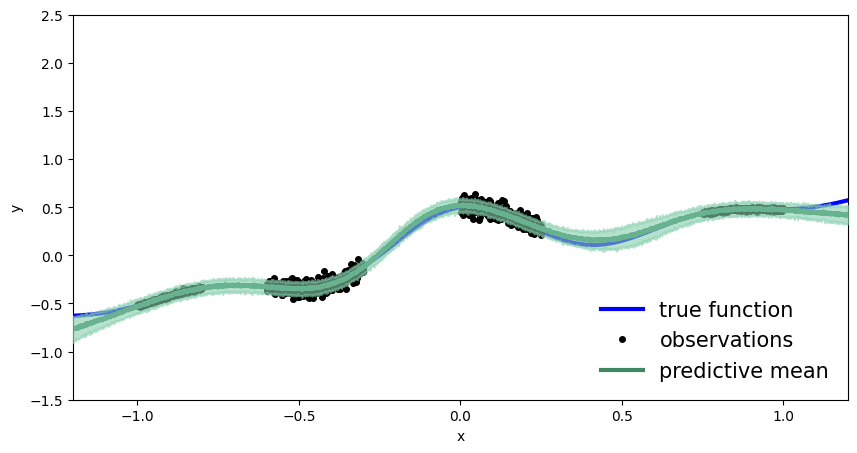

In [ ]:
from pyro.infer import Predictive

predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
x_test = torch.linspace(-1.2, 1.2, 3000)
preds = predictive(x_test)

def plot_predictions(preds):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    xlims = [-0.5, 1.5]
    ylims = [-1.5, 2.5]
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel("x")
    plt.ylabel("y")

    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    ax.plot(x_obs, y_obs, 'ko', markersize=4, label="observations")
    ax.plot(x_obs, y_obs, 'ko', markersize=3)
    ax.plot(x_test, y_pred, '-', linewidth=3, color="#408765", label="predictive mean")
    ax.fill_between(x_test, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

    plt.legend(loc=4, fontsize=15, frameon=False)

plot_predictions(preds)
